## Imports

In [180]:
# all my imports
import importlib

from data import data_generation
importlib.reload(data_generation)
from data.data_generation import *

from utils import helper_functions
importlib.reload(helper_functions)
from utils.helper_functions import *

from models import logistic_regression
importlib.reload(logistic_regression)
from models.logistic_regression import *

from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

from training import training
importlib.reload(training)
from training.training import *

import experiments
importlib.reload(experiments)
from experiments import *

from training import subgroup_aware_clipping
importlib.reload(subgroup_aware_clipping)
from training.subgroup_aware_clipping import *


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils

## Sample size sweep - done
The purpose of this is to determine the smallest sample size where:
1. Nonprivate training performs well on all subgroups
2. Private training performs well overall and on majority but not on the minority

Then, this sample size will be used for the remaining sweeps.

In [61]:
# sample size sweep
import subprocess

sample_sizes = [10000, 25000, 30000, 50000, 70000]
processes = []

for s in sample_sizes:
    log_file = open(f"logs/samplesize_sweep_{s}.log", "w")
    cmd = ["python3", "experiments/run_samplesize_sweep.py", "--num_samples", str(s)]
    p = subprocess.Popen(cmd, stdout=log_file, stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} subprocesses.")


Launched 5 subprocesses.


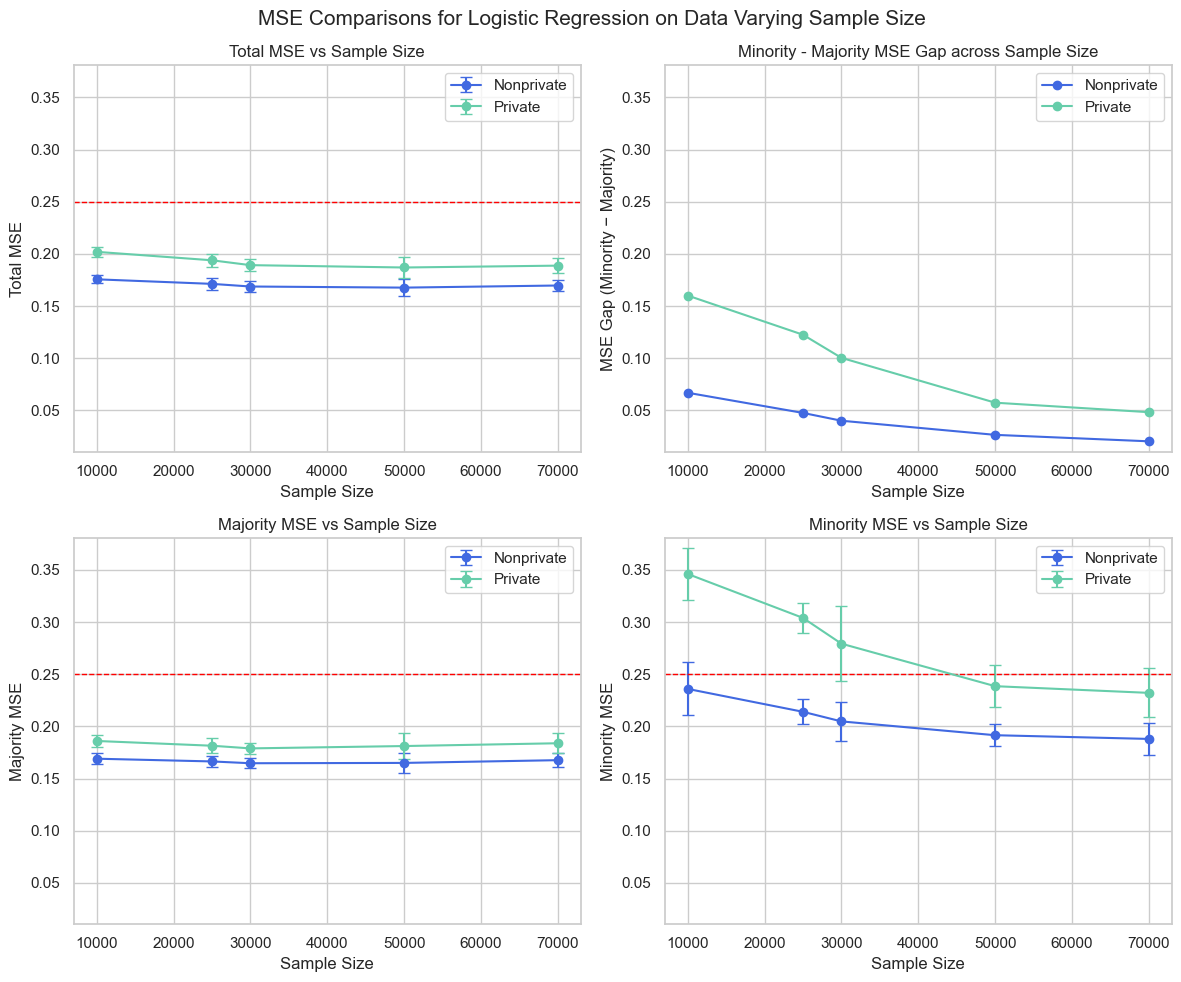

In [141]:
# get the 2x2 plots for paper
from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

plot_summary_from_csvs(
    varname="samplesize",
    varname_title = "Sample Size",
    var_values=sample_sizes
)

In [68]:
# perform the ANOVA test to determine statistical significance of dataset size + privacy 

from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

samplesize_anova = run_anova_gap("samplesize", sample_sizes)
print_anova_table(samplesize_anova, "Sample Size")


Two-way ANOVA Results for Group MSE Gap by Privacy and Sample Size
                            sum_sq    df           F        PR(>F)
C(privacy)                0.082426   1.0  119.959639  3.065421e-18
C(samplesize)             0.083431   4.0   30.355518  5.470103e-16
C(privacy):C(samplesize)  0.015849   4.0    5.766465  3.537945e-04
Residual                  0.061841  90.0         NaN           NaN


In [60]:
for i, p in enumerate(processes):
    print(f"Process {i} alive:", p.poll() is None)


Process 0 alive: False
Process 1 alive: False
Process 2 alive: False
Process 3 alive: False
Process 4 alive: False


## Minority Group Parameter Sweeps (fraction, noise, bias)
The dataset size chosen via the previous experiment is ____.
The purpose of these sweeps is to figure out which parameter settings exacerbate the group MSE gap most in the private setting, while the non-private setting MSE remains good (i.e. below 0.2) on both subgroups.

In [113]:
# minority fraction sweep
import subprocess
import os

os.makedirs("logs", exist_ok=True)

min_fracs = [0.05, 0.1, 0.15, 0.2, 0.3]
processes = []

for f in min_fracs:
    safe_f = str(f).replace(".", "p").replace("-", "neg")
    log_file = open(f"logs/minfrac_sweep_{safe_f}.log", "w")
    cmd = ["python3", "experiments/run_minfrac_sweep.py", "--min_frac", str(f)]
    p = subprocess.Popen(cmd, stdout=log_file, stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} subprocesses.")

Launched 5 subprocesses.


In [144]:
# minority flip prob sweep
import subprocess
import os

os.makedirs("logs", exist_ok=True)

flip_mins = [0.1, 0.15, 0.2, 0.3]
processes = []

for f in flip_mins:
    safe_f = str(f).replace(".", "p").replace("-", "neg")
    log_file = open(f"logs/minflip_sweep_{safe_f}.log", "w")
    cmd = ["python3", "experiments/run_minflip_sweep.py", "--flip_min", str(f)]
    p = subprocess.Popen(cmd, stdout=log_file, stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} subprocesses.")


Launched 4 subprocesses.


In [145]:
# minority bias sweep
import subprocess
import os

os.makedirs("logs", exist_ok=True)

min_biases = [0.5, 1.0, 2.0, 3.0]
processes = []

for b in min_biases:
    safe_b = str(b).replace(".", "p").replace("-", "neg")
    log_file = open(f"logs/minbias_sweep_{safe_b}.log", "w")
    cmd = ["python3", "experiments/run_minbias_sweep.py", "--min_bias", str(b)]
    p = subprocess.Popen(cmd, stdout=log_file, stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} subprocesses.")


Launched 4 subprocesses.


The plots for each sweep are below.

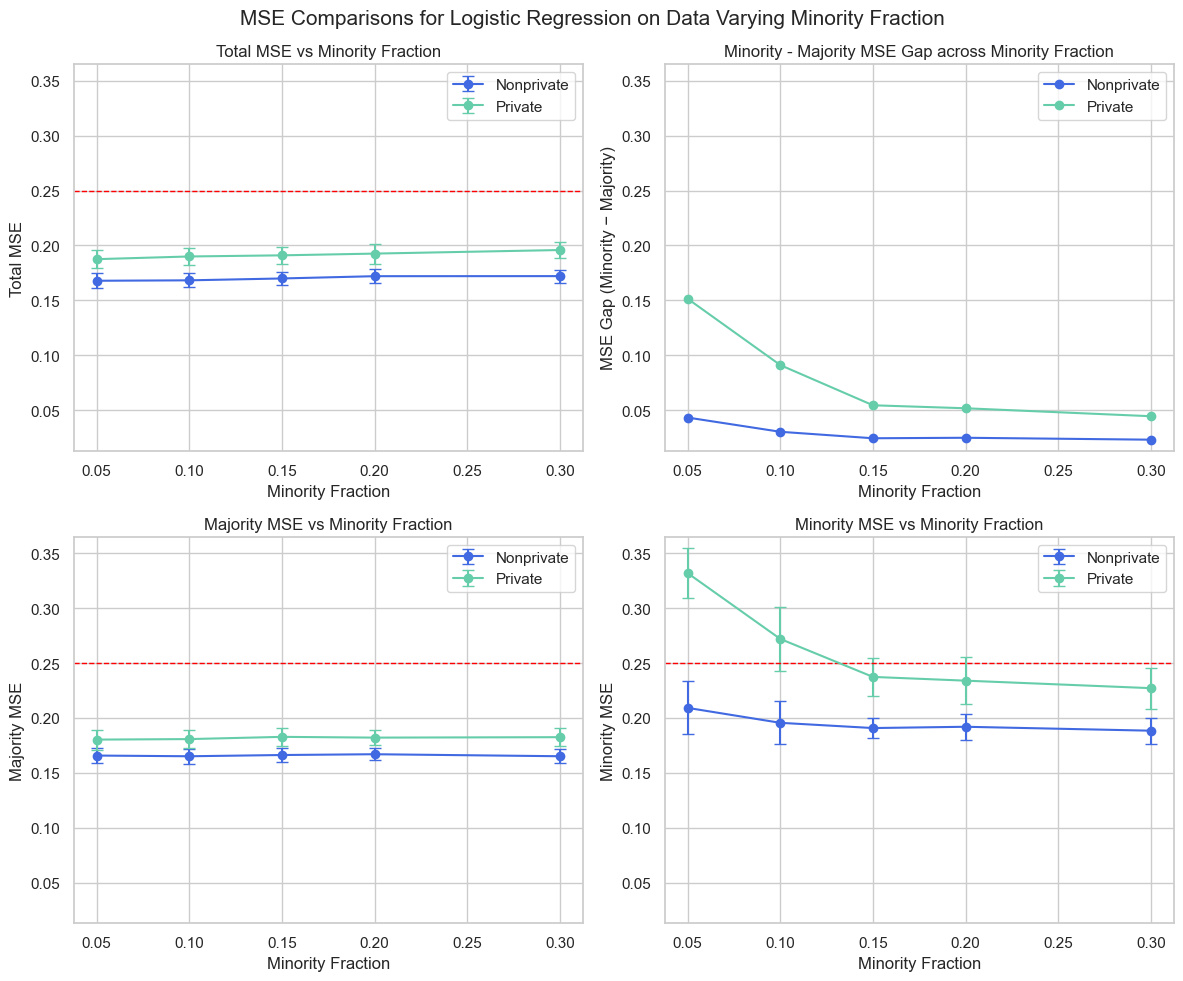

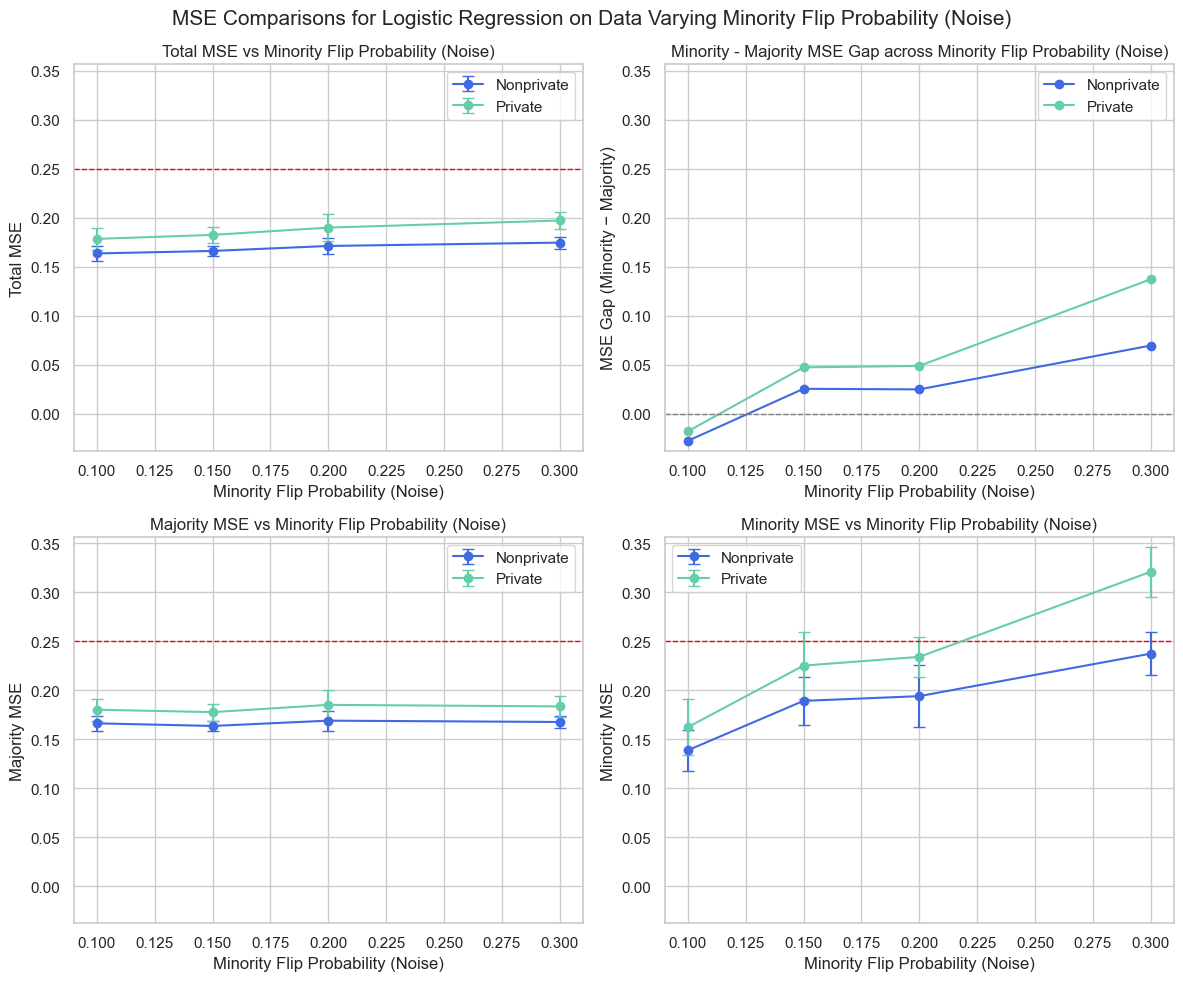

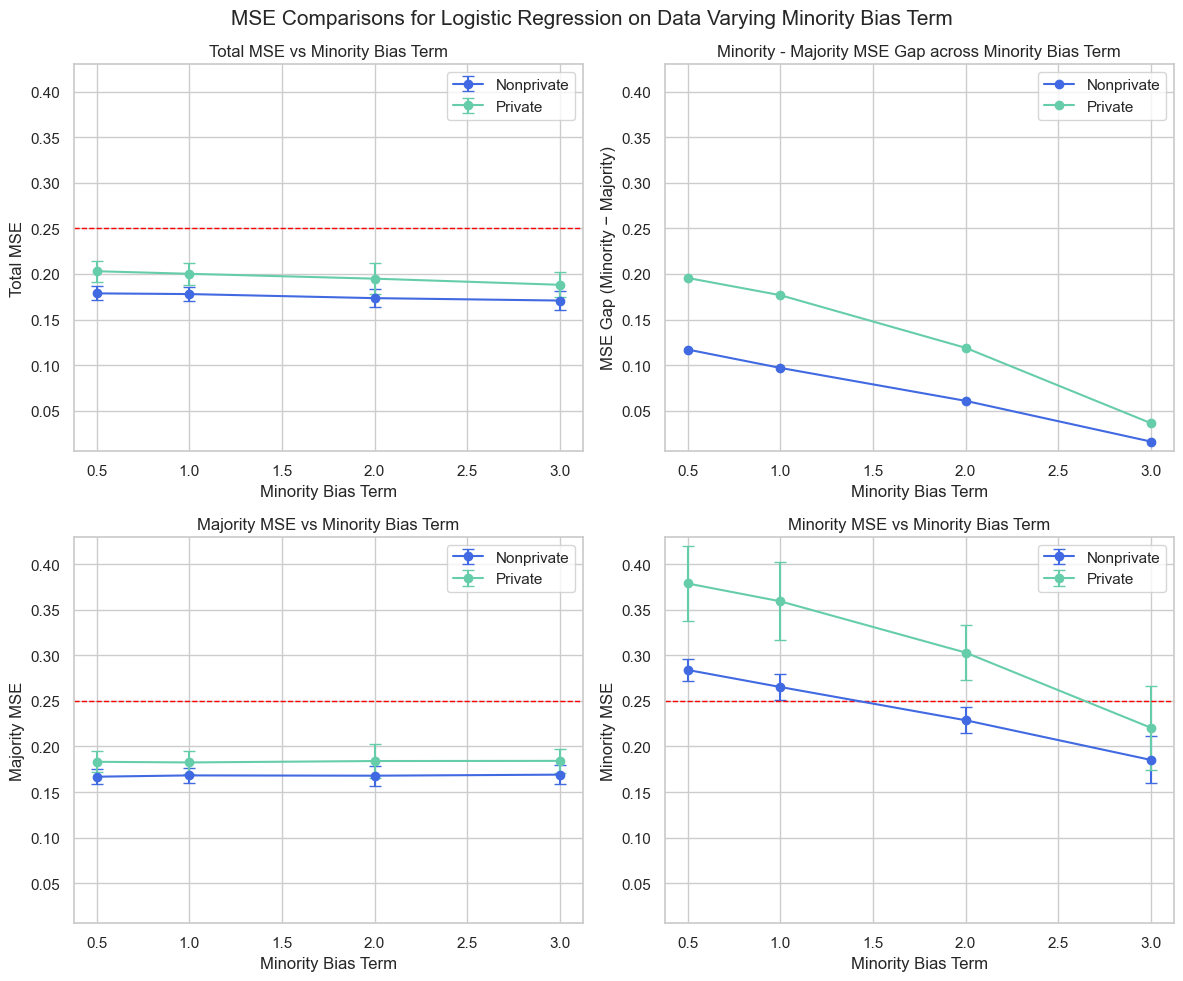

In [165]:
# get the 2x2 plots for each
from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

plot_summary_from_csvs(
    varname="minfrac",
    varname_title = "Minority Fraction",
    var_values=min_fracs
)

plot_summary_from_csvs(
    varname="minflip",
    varname_title = "Minority Flip Probability (Noise)",
    var_values=flip_mins
)

plot_summary_from_csvs(
    varname="minbias",
    varname_title = "Minority Bias Term",
    var_values=min_biases
)

Finally we have the two-way ANOVA tests to determine the significance of the effect of privacy and the level of the variables we swept over (including an interaction term).

In [166]:
# perform the ANOVA tests

from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

minfrac_anova = run_anova_gap("minfrac", min_fracs)
print_anova_table(minfrac_anova, "Minority Fraction")

minflip_anova = run_anova_gap("minflip", flip_mins)
print_anova_table(minflip_anova, "Minority Flip Probability")

minbias_anova = run_anova_gap("minbias", min_biases)
print_anova_table(minbias_anova, "Minority Bias")


Two-way ANOVA Results for Group MSE Gap by Privacy and Minority Fraction
                         sum_sq    df           F        PR(>F)
C(privacy)             0.061001   1.0  134.326742  1.524505e-19
C(minfrac)             0.055701   4.0   30.664362  4.226006e-16
C(privacy):C(minfrac)  0.026210   4.0   14.428995  3.852841e-09
Residual               0.040871  90.0         NaN           NaN

Two-way ANOVA Results for Group MSE Gap by Privacy and Minority Flip Probability
                         sum_sq    df          F        PR(>F)
C(privacy)             0.018959   1.0  20.591457  2.223576e-05
C(minflip)             0.159773   3.0  57.843855  3.821603e-19
C(privacy):C(minflip)  0.009665   3.0   3.499117  1.973938e-02
Residual               0.066292  72.0        NaN           NaN

Two-way ANOVA Results for Group MSE Gap by Privacy and Minority Bias
                         sum_sq    df          F        PR(>F)
C(privacy)             0.069954   1.0  58.504094  6.926815e-11
C(minbias)   

## Gradient Experiments

Given the settings found above that most exacerbated disparities, we run non-private training and collect per-sample gradients every 10 epochs to determine the average and variance of gradients per subgroup. The purpose of this is to:

1. Inform the gradient clipping ranges we will use for the minority and majority groups in our new scheme
2. We will then compare our group-aware clipping training to the nonprivate and standard private trainings for these parameter regimes to evaluate efficacy

In [176]:
import subprocess
import os

os.makedirs("logs", exist_ok=True)

settings = [
    {"min_fraction": 0.05, "min_signal": 0.5, "flip_min": 0.15},
    {"min_fraction": 0.05, "min_signal": 0.5, "flip_min": 0.2},
    {"min_fraction": 0.05, "min_signal": 1.0, "flip_min": 0.15},
    {"min_fraction": 0.05, "min_signal": 1.0, "flip_min": 0.2},
    {"min_fraction": 0.1,  "min_signal": 0.5, "flip_min": 0.15},
    {"min_fraction": 0.1,  "min_signal": 0.5, "flip_min": 0.2},
    {"min_fraction": 0.1,  "min_signal": 1.0, "flip_min": 0.15},
    {"min_fraction": 0.1,  "min_signal": 1.0, "flip_min": 0.2},
]

processes = []
for setting_idx in range(len(settings)):
    log_file = open(f"logs/setting_{setting_idx}.txt", "w")
    p = subprocess.Popen(["python3", "experiments/run_gradient_tracking.py", str(setting_idx)],
                         stdout=log_file,
                         stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} tracking runs.")


Launched 8 tracking runs.


In [ ]:
# run gradient experiments for the minority bias sweep
processes = []
for setting_idx in range(7):
    log_file = open(f"logs/bias_setting_{setting_idx}.txt", "w")
    p = subprocess.Popen(["python3", "experiments/run_gradient_tracking.py", str(setting_idx)],
                         stdout=log_file,
                         stderr=subprocess.STDOUT)
    processes.append(p)

print(f"Launched {len(processes)} tracking runs.")

Launched 7 tracking runs.


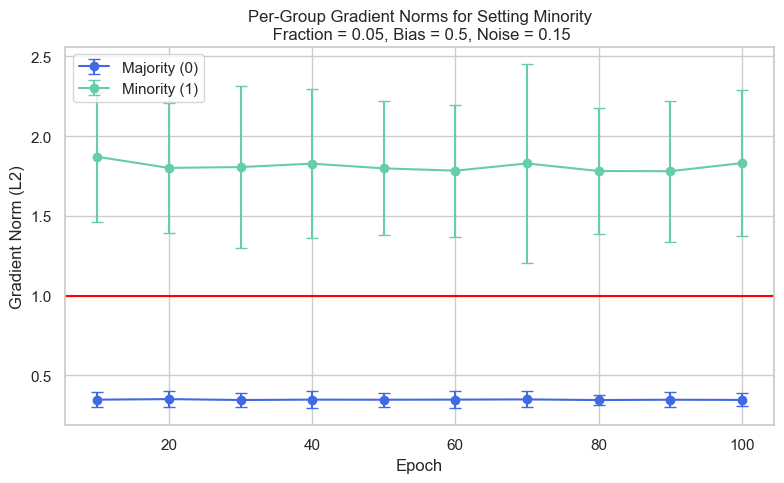

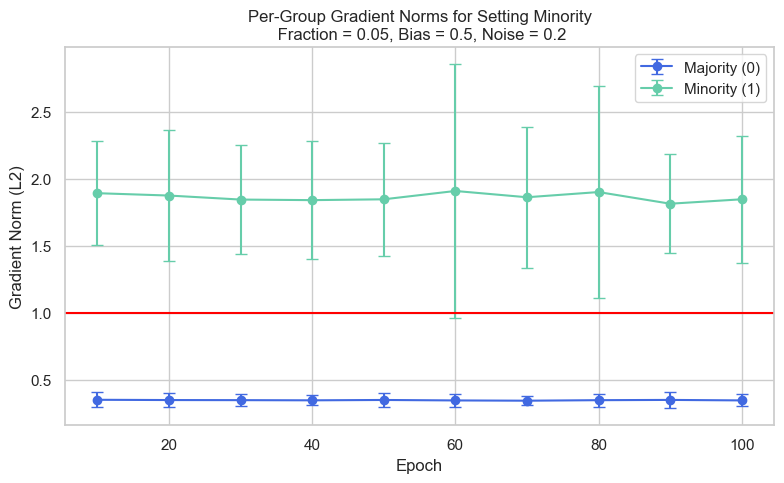

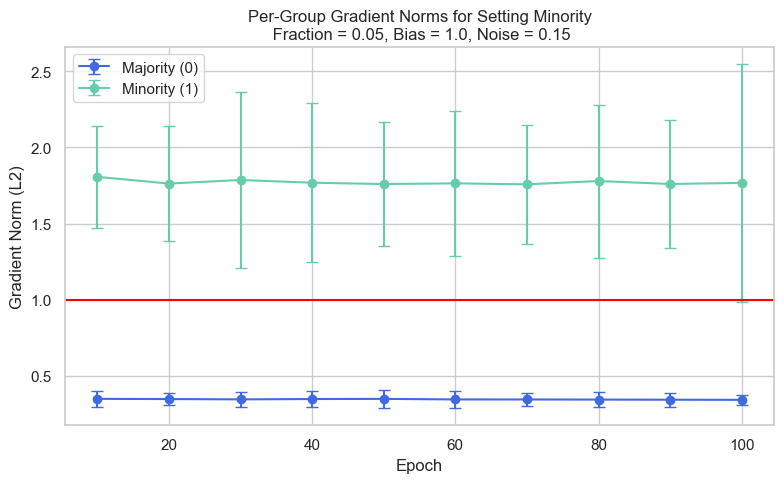

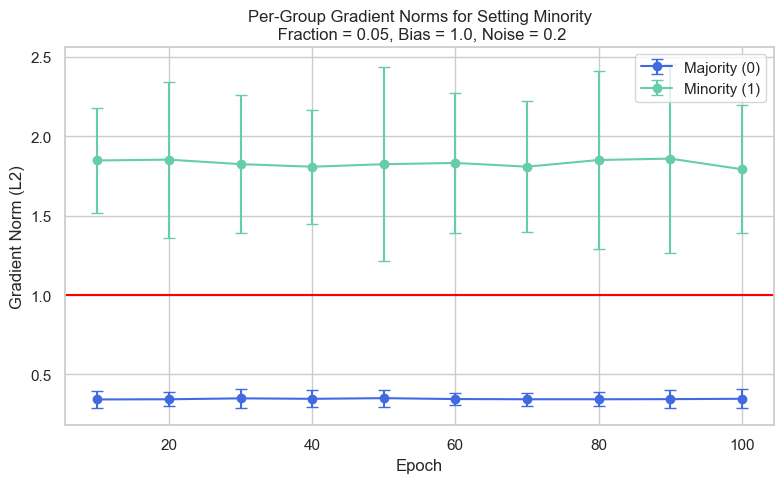

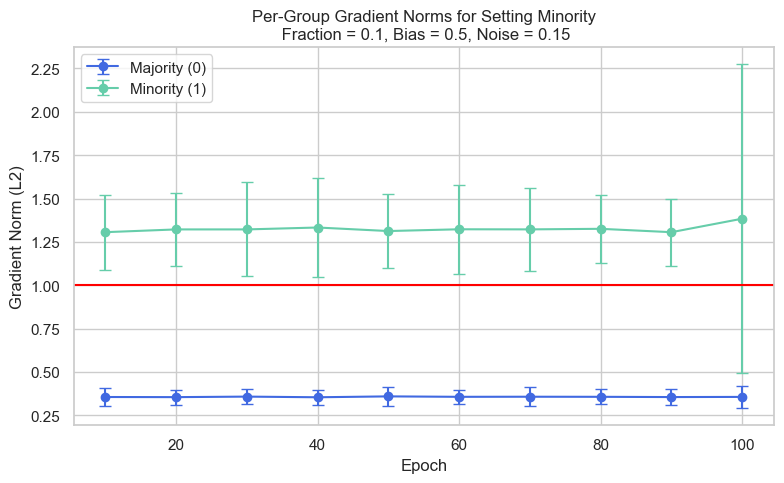

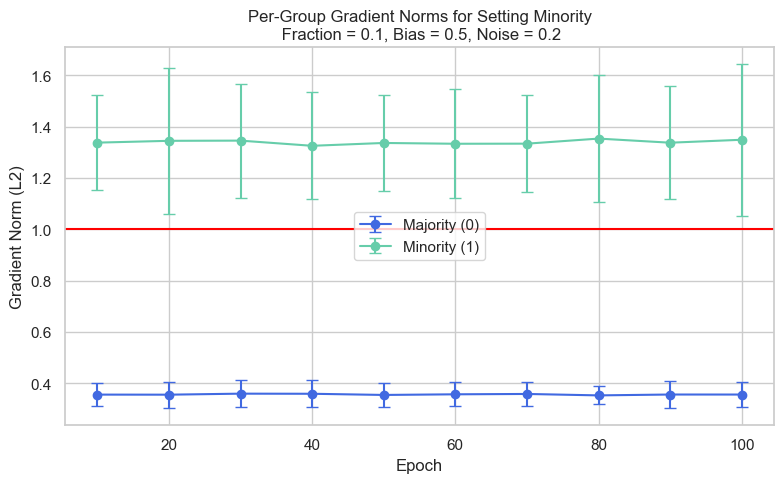

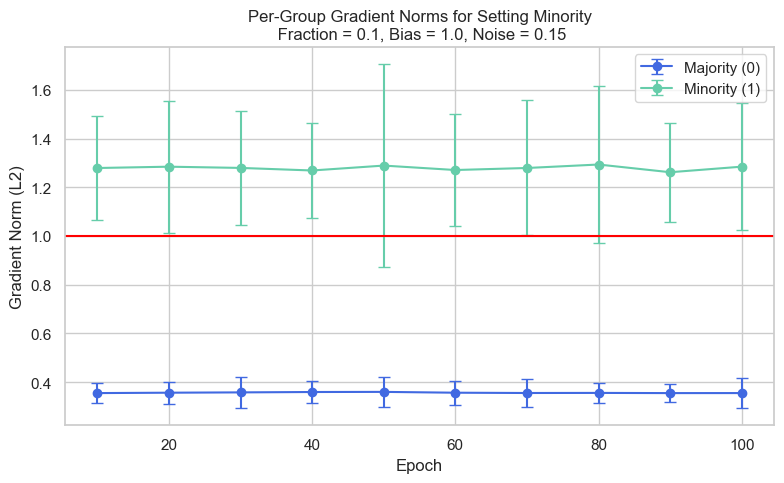

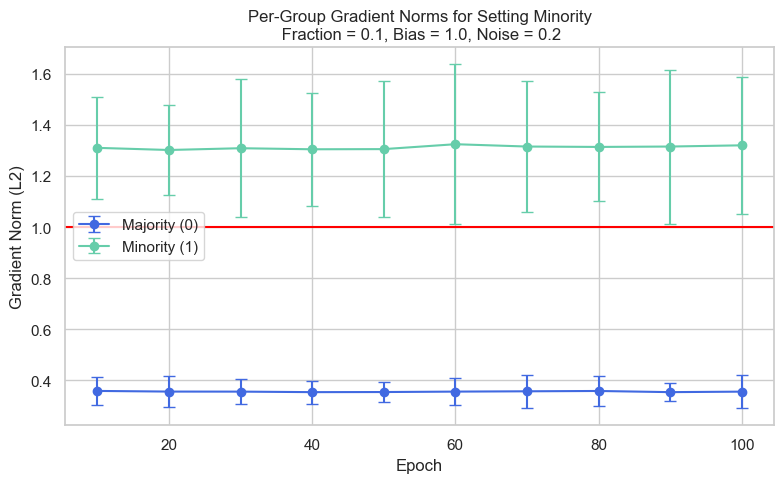

In [178]:
from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

# this plots the mean + stdev of per-sample gradients every 10 epochs, for minority and majority groups

for i in range(len(settings)):
    plot_gradient_norms(i, settings)

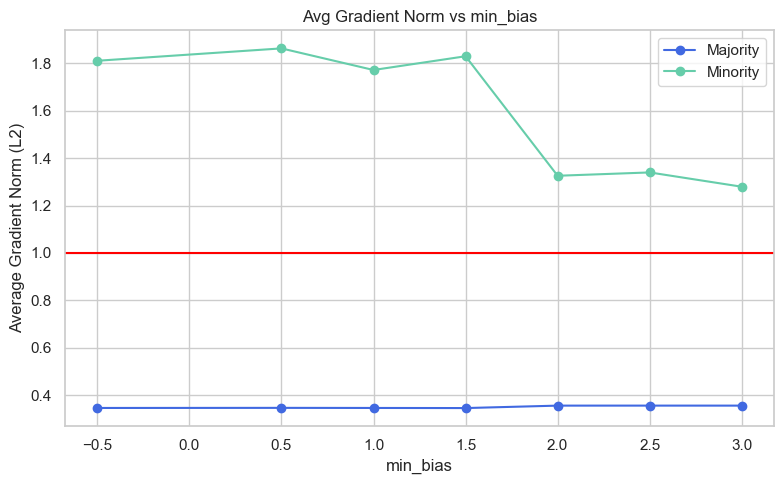

In [189]:
from utils import evaluation
importlib.reload(evaluation)
from utils.evaluation import *

# this plots the mean + stdev of per-sample gradients every 10 epochs, for minority and majority groups
settings2 = [
        {"min_fraction": 0.1, "min_signal": -0.5, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 0.5, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 1.0, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 1.5, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 2.0, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 2.5, "flip_min": 0.2},
        {"min_fraction": 0.1, "min_signal": 3.0, "flip_min": 0.2},
        
    ]
# for i in range(len(settings2)):
#     plot_gradient_norms(i, settings2, other = "bias")
plot_avg_gradient_norms_vs_bias(settings2)

## Subgroup-Aware Clipping Experiments
1. Sweep over the max majority norm and max minority norm based on the above gradient experiments
2. Identify the settings with greatest improvement for each of the eight settings above
3. Compare to non-private and standard private graphically/visually
4. Compare to standard private via ANOVA (hopefully significant difference)
5. Compare to non-private via ANOVA (hopefully non-significant difference?)

In [ ]:
from joblib import Parallel, delayed
import torch
import csv
import os
from training.subgroup_aware_clipping import *
from utils.evaluation import *
from utils.helper_functions import *

maj_signal = -2.0
flip_maj = 0.05
dim = 200
n_train = 30000
num_samples = n_train
seed = 13
lr = 0.1
wd = 1e-4
num_epochs = 30
eps = 1.0
delta = 1 / (n_train ** 2)

maj_clip_vals = [0.5]
min_clip_vals = [1.5, 1.75, 2.0, 2.25, 2.5]
min_signals = [0.5, 1.0, 2.0, 3.0]

log_file = "save_results/grid_search_across_biases.csv"
os.makedirs("save_results", exist_ok=True)

def run_experiment(min_signal, max_maj, max_min, mode):
    min_frac = 0.1
    flip_min = 0.2

    train_data = generate_data_weight_and_bias(n_train, dim, min_frac, min_signal, maj_signal, flip_min, flip_maj, seed)
    loader = make_dataloader_flags(train_data, batch_size=256)

    val_data = generate_data_weight_and_bias(500, dim, min_frac, min_signal, maj_signal, flip_min, flip_maj, seed + 1)
    X_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float32), val_data)
    X_val_aug = augment_x(X_val, g_val.view(-1, 1))

    if mode == "StandardPrivate":
        model = StratifiedLogisticRegression(dim)
        train_private_standard(model, loader, num_epochs, lr, wd, eps, delta, 1.0)
        clip_vals = (1.0, 1.0)
    else:
        model = StratifiedLogisticRegression(dim)
        train_private_group_aware(
            model,
            dataloader=loader,
            num_epochs=num_epochs,
            lr=lr,
            weight_decay=wd,
            target_epsilon=eps,
            max_majority=max_maj,
            max_minority=max_min,
            total_samples=num_samples,
            delta=delta
        )
        clip_vals = (max_maj, max_min)

    with torch.no_grad():
        overall = mse(model, X_val, y_val, g_val)
        maj_mse, min_mse = group_mse(model, X_val, y_val, g_val)
        gap = abs(maj_mse - min_mse)

    return [min_signal, clip_vals[0], clip_vals[1], overall, maj_mse, min_mse, gap, mode]

jobs = []
for min_signal in min_signals:
    jobs.append(delayed(run_experiment)(min_signal, 1.0, 1.0, "StandardPrivate"))
print("done with std priv")
for min_signal in min_signals:
    for max_min in min_clip_vals:
        jobs.append(delayed(run_experiment)(min_signal, 0.5, max_min, "GroupAware"))

results = Parallel(n_jobs=-1)(jobs)

write_header = not os.path.exists(log_file)
with open(log_file, mode='a', newline='') as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow([
            "MinBias", "MaxClip", "MinClip", "OverallMSE",
            "MajorityMSE", "MinorityMSE", "GroupGap", "Type"
        ])
    writer.writerows(results)


done with std priv


/usr/local/Caskroom/miniconda/base/envs/privatails/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/privatails/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/privatails/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/Caskroo

Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0


/usr/local/Caskroom/miniconda/base/envs/privatails/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/Caskroom/miniconda/base/envs/privatails/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/Caskroom/miniconda/base/envs/privatails

(ε = 0.99, δ = 1.6e-07)
(ε = 0.99, δ = 1.6e-07)
(ε = 0.99, δ = 1.6e-07)
(ε = 0.99, δ = 1.6e-07)
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 10/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 20/30
done with epoch 30/30
(ε = 0.99, δ = 1.6e-07)
done with epoch 30/30
(ε = 0.99, δ = 1.6e-07)
done with epoch 30/30
(ε = 0.99, δ = 1.6e-07)
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multiplier = 8.8789 for ε = 1.0
done with epoch 30/30
(ε = 0.99, δ = 1.6e-07)
Calibrated noise_multiplier = 8.8789 for ε = 1.0
Calibrated noise_multipli

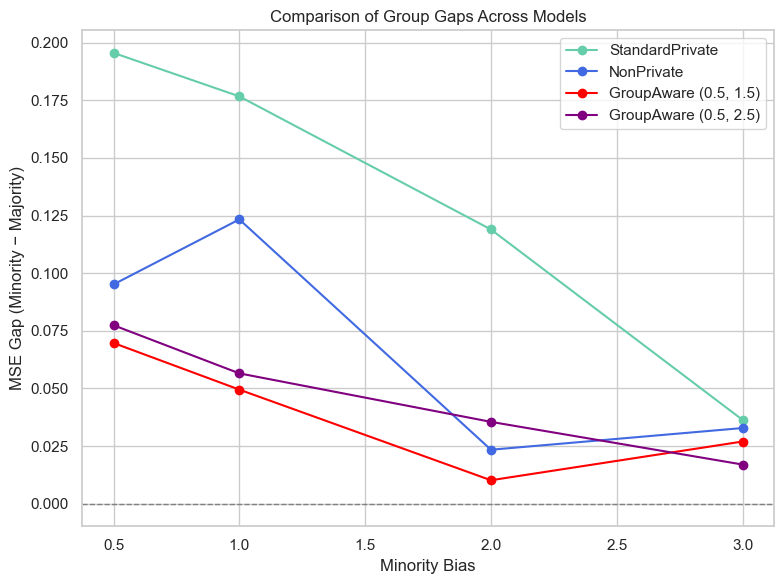

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from training.subgroup_aware_clipping import *
from utils.helper_functions import *
from data.data_generation import *
from utils.evaluation import *

min_biases = [0.5, 1.0, 2.0, 3.0]
compare_gap_traces(min_biases)


In [214]:
import pandas as pd
from scipy.stats import f_oneway

df = pd.read_csv("save_results/grid_search_across_biases.csv")
groupaware_gaps = df[df["Type"] == "GroupAware"]["GroupGap"]
stdprivate_gaps = df[df["Type"] == "StandardPrivate"]["GroupGap"]
f_stat, p_val = f_oneway(groupaware_gaps, stdprivate_gaps)

print(f"F-stat: {f_stat:.4f}")
print(f"p-val: {p_val:.4e}")

if p_val < 0.05:
    print("Statistically significant difference between group-aware and standard private gaps.")
else:
    print("No statistically significant difference between the two.")

F-stat: 4.6972
p-val: 4.0812e-02
Statistically significant difference between group-aware and standard private gaps.
